<a href="https://colab.research.google.com/github/Zibraan/My_DataScience_Codes/blob/main/Leaf_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'C:\\Users\\Admin'

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import time
import json
import tensorflow_hub as hub
import os
from os.path import exists
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pylab as plt
import numpy as np
import cv2

import itertools
import random
from collections import Counter
from glob import iglob

In [ ]:
# zip_file = tf.keras.utils.get_file(origin='C:/Users/Admin/OneDrive/Desktop/project/rice-leaf.zip',fname='rice-leaf.zip', extract=True)

data_dir = 'C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice'
print(data_dir)
train_dir = 'C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice/train'
validation_dir ='C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice/validation'


def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " files"

print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice
total images for training : C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice/train : 157 files
total images for validation : C:/Users/Admin/OneDrive/Desktop/project/rice-leaf/rice/validation : 84 files


In [ ]:
with open('C:/Users/Admin/OneDrive/Desktop/project/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print (classes)

print('Number of classes:',len(classes))

['Bacterial_leaf_blight', 'blast', 'brownspot']
Number of classes: 3


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True

  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False


print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])


model.summary()

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2 with input size (224, 224) and output dimension 1280
Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
LEARNING_RATE = 0.001

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])



EPOCHS=150 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20444\3933008269.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/150
2/2 [==============================] - 14s 4s/step - loss: 2.0657 - accuracy: 0.3656 - val_loss: 3.8414 - val_accuracy: 0.0156
Epoch 2/150
2/2 [==============================] - 7s 4s/step - loss: 1.3392 - accuracy: 0.6016 - val_loss: 0.6828 - val_accuracy: 0.6875
Epoch 3/150
2/2 [==============================] - 6s 5s/step - loss: 0.6674 - accuracy: 0.7742 - val_loss: 1.3916 - val_accuracy: 0.6719
Epoch 4/150
2/2 [==============================] - 7s 4s/step - loss: 0.5149 - accuracy: 0.7891 - val_loss: 1.1107 - val_accuracy: 0.6719
Epoch 5/150
2/2 [==============================] - 7s 4s/step - loss: 0.2638 - accuracy: 0.8828 - val_loss: 1.2595 - val_accuracy: 0.5312
Epoch 6/150
2/2 [==============================] - 6s 5s/step - loss: 0.1758 - accuracy: 0.9355 - val_loss: 1.4896 - val_accuracy: 0.5156
Epoch 7/150
2/2 [==============================] - 6s 3s/step - loss: 0.2345 - accuracy: 0.9462 - val_loss: 1.5603 - val_accuracy: 0.5156
Epoch 8/150
2/2 [================

Epoch 60/150
2/2 [==============================] - 7s 4s/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 1.7263 - val_accuracy: 0.7188
Epoch 61/150
2/2 [==============================] - 7s 4s/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 1.7875 - val_accuracy: 0.7188
Epoch 62/150
2/2 [==============================] - 8s 5s/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.8093 - val_accuracy: 0.7188
Epoch 63/150
2/2 [==============================] - 7s 4s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.8450 - val_accuracy: 0.7031
Epoch 64/150
2/2 [==============================] - 7s 4s/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.8461 - val_accuracy: 0.7188
Epoch 65/150
2/2 [==============================] - 6s 3s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 1.8447 - val_accuracy: 0.7188
Epoch 66/150
2/2 [==============================] - 6s 3s/step - loss: 0.0335 - accuracy: 0.9892 - val_loss: 1.8452 - val_accuracy: 0.7188
Epoch 67/150
2/2 [=========

Epoch 119/150
2/2 [==============================] - 6s 3s/step - loss: 0.0189 - accuracy: 0.9892 - val_loss: 2.0688 - val_accuracy: 0.6875
Epoch 120/150
2/2 [==============================] - 6s 3s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.1725 - val_accuracy: 0.6875
Epoch 121/150
2/2 [==============================] - 7s 4s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 2.2443 - val_accuracy: 0.6875
Epoch 122/150
2/2 [==============================] - 7s 4s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.2652 - val_accuracy: 0.6719
Epoch 123/150
2/2 [==============================] - 6s 3s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.2739 - val_accuracy: 0.6719
Epoch 124/150
2/2 [==============================] - 7s 4s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.2865 - val_accuracy: 0.6719
Epoch 125/150
2/2 [==============================] - 6s 4s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.3032 - val_accuracy: 0.6719
Epoch 126/150
2/2 [=

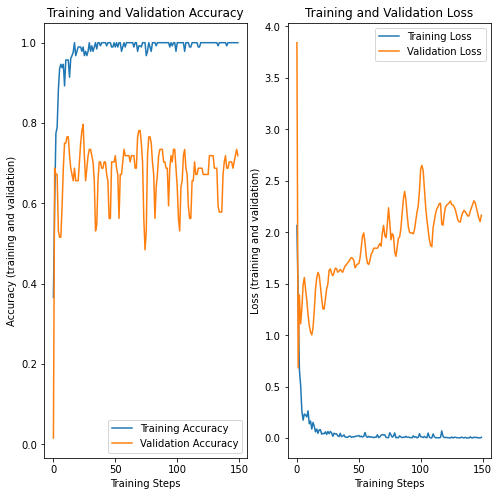

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_020.PNG
1/1 [==============================] - 1s 820ms/step
PREDICTED: class: Bacterial_leaf_blight, Accuracy: 0.992399


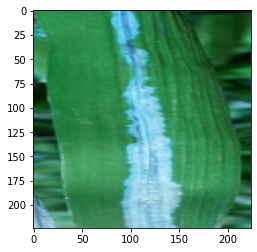

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_039.jpg
1/1 [==============================] - 0s 59ms/step
PREDICTED: class: Bacterial_leaf_blight, Accuracy: 0.999596


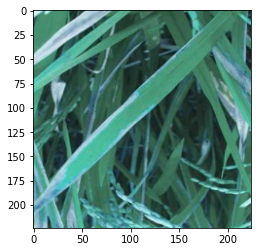

SOURCE: class: blast, file: blast\blast_rotated_021.jpg
1/1 [==============================] - 0s 59ms/step
PREDICTED: class: blast, Accuracy: 0.916695


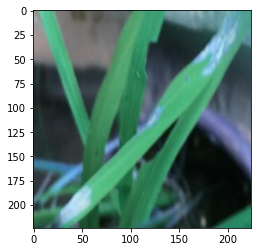

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast\blast_rotated_017.jpg
1/1 [==============================] - 0s 59ms/step
PREDICTED: class: brownspot, Accuracy: 0.981343


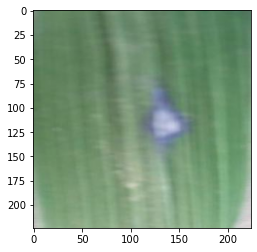

<Figure size 432x288 with 0 Axes>

SOURCE: class: brownspot, file: brownspot\brownspot_rotated_006.png
1/1 [==============================] - 0s 60ms/step
PREDICTED: class: Bacterial_leaf_blight, Accuracy: 0.988776


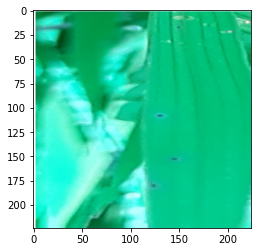

<Figure size 432x288 with 0 Axes>

In [ ]:
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, Accuracy: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [ ]:
pwd

'C:\\Users\\Admin'

In [ ]:
copy this file to deskto